In [2]:
import numpy as np
import os

In [ ]:
# make sure that conversion went ok
imgPath = os.path.join('ignore','data', 'num32train', 'BRATS_001.nii.gz.npy')
img = np.load(imgPath)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
slices = [20,40]
num_channels = img.shape[0]
k = 1
for slice in slices:
    for j in range(num_channels):
        plt.subplot(num_channels,num_channels,k)
        plt.axis('off')
        plt.imshow(img[j,:,:,slice])
        k+=1
plt.show()

In [ ]:
imgPath = os.path.join('ignore','data', 'num32labels', 'BRATS_001.nii.gz.npy')
img = np.load(imgPath)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img[:,:,30])
plt.show()

# Architectures
Here is an article with several architectures:
https://medium.com/@arthur_ouaknine/review-of-deep-learning-algorithms-for-image-semantic-segmentation-509a600f7b57

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [29]:
# IoU Score
# https://cdn-images-1.medium.com/max/1600/1*aXXnB2IEA7DalpGNr3X59g.png
def iou_score(y_pred, y, SMOOTH=1e-6, rounding=False):
    """
    aka Jaccard
    expect: y_pred, y to be of SAME integer type
    
    y_pred is output of model
        expect: y_pred.shape = (batch_len,D,D,S)
        (no channels!)
    y is truth value (labels)
        expect: y.shape = (batch_len,D,D,S)
    
    returns: the mean across the batch of the iou scores
    """
    # sanity check
    assert y_pred.shape == y.shape
    # to compute scores, we sum along all axes except for batch
    axes = tuple([i for i in range(1,len(y.shape))])
    batch_len = y.shape[0]
    # if y_pred hasn't been rounded
    if rounding:
        y_pred = y_pred.round()
    
    intersection = (y_pred & y).sum(dim=axes).float()
    union = (y_pred | y).sum(dim=axes).float()
    # sanity check
    assert intersection.shape == union.shape
    assert union.shape == (batch_len,)
    
    iou = 1 - (intersection + SMOOTH) / (union + SMOOTH)
    
    return iou.mean()

def iou_loss(y_pred, y, SMOOTH=1e-6):
    """
    essentially returns 1 - iou_score
    but takes care of y_pred not being rounded
    """
    assert y_pred.shape == y.shape
    axes = tuple([i for i in range(1,len(y.shape))])
    batch_len = y.shape[0]
    
    numerator = y*y_pred
    numerator = numerator.sum(dim=axes)
    a = y.sum(dim=axes)
    b = y.sum(dim=axes)
    denominator = a + b - numerator
    quotient = (numerator + SMOOTH) / (denominator + SMOOTH)
    return quotient.mean()

class iou_module(nn.Module):
    def __init__(self):
        super(iou_module,self).__init__()

    def forward(self, y_pred, y):
        loss = iou_loss(y_pred, y)
        return loss

In [36]:
# simulate data
def simulator(model,criterion,batch_len=1,C=4,D=32,S=64):
    # simulate input data
    x = torch.randn(batch_len,C,D,D,S)
    print(f"Input has shape {tuple(x.shape)}.")
    # simulate output data
    y = torch.randn(batch_len,D,D,S)
    y = torch.sigmoid(y).round()
    print(f"Target has shape {tuple(y.shape)}.")
    # simulate prediction for training
    y_pred = model(x, evaluating=False)
    print(f"Training output has shape {tuple(y_pred.shape)}.")
    # compute loss
    loss = criterion(y_pred,y)
    print(f"Loss is {loss.item()}.")
    
    loss.backward()
    print("Backward pass works.")
    
    # simulate prediction for evaluating
    y_pred = model(x, evaluating=True)
    print(f"Evaluation output has shape {tuple(y_pred.shape)}.")
    # convert to int type
    # x.byte() is equivalent to x.to(dtype=torch.uint8)
    # https://pytorch.org/docs/stable/tensors.html
    y_pred = y_pred.byte()
    y = y.byte()
    score = iou_score(y_pred,y).item()
    print(f"IoU score is {score}.")

    # simulate segmentation comparison
    y_pred = y_pred[0].cpu().detach().numpy()
    y = y[0].cpu().detach().numpy()
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(y_pred[:,:,35])
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(y[:,:,35])
    
    plt.show()

In [37]:
# Pixelwise Logistic Regression (bad for your health)
class PixLog(nn.Module):
    def __init__(self,C=4,D=32,S=64):
        super(PixLog,self).__init__()
        
        self.dimensions = (C,D,D,S)
        self.fc = nn.Linear(in_features=C*D*D*S, out_features=D*D*S,bias=True)
        self.sig = nn.Sigmoid()
        
    def forward(self, x_in, evaluating=False):
        batch_len = x_in.shape[0]
        x = x_in.view(batch_len,-1)
        x = self.fc(x)
        
        if evaluating:
            x = self.sig(x)
            x = x.round()
        
        dummy_dim = (-1,) + self.dimensions[1:]
        x_out = x.view(dummy_dim)
        return x_out

# If you even try to initialize this, you're gonna have a bad time.
# loss = nn.BCEWithLogitsLoss()

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 0.706767737865448.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
IoU score is 0.6669915914535522.


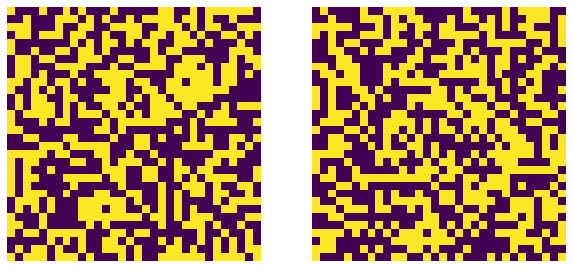

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 0.0008251722902059555.
Backward pass works.
Evaluation output has shape (1, 32, 32, 64).
IoU score is 0.664172887802124.


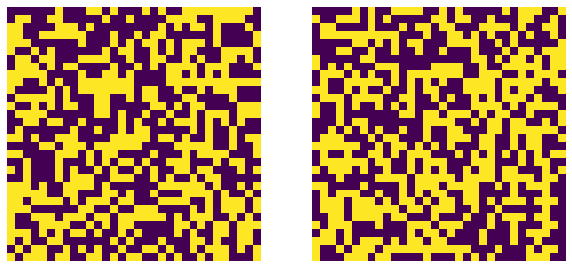

In [40]:
# a simple encoderdecoder-type model
class Crush(nn.Module):
    def __init__(self,D=32,S=64,C=4,crush_size=32):
        super(Crush,self).__init__()
        
        self.dimensions = (C,D,D,S)
        self.in_features = int(D*D*S*C)
        self.crush = crush_size
        self.out_features = int(D*D*S)
        self.enc = nn.Linear(in_features=self.in_features,out_features=self.crush,bias=True)
        self.act = nn.ReLU()
        self.dec = nn.Linear(in_features=self.crush,out_features=self.out_features)
        self.sig = nn.Sigmoid()
    
    def forward(self, x_in, evaluating=False):
        batch_len = x_in.shape[0]
        x = x_in.view(batch_len,-1)
        x = self.enc(x)
        x = self.act(x)
        x = self.dec(x)
        
        if evaluating:
            x = self.sig(x)
            x = x.round()
        
        dummy_dim = (-1,) + self.dimensions[1:]
        x_out = x.view(dummy_dim)
        return x_out


model = Crush()
optimizer = torch.optim.Adam(model.parameters())
# loss = nn.BCEWithLogitsLoss()
# should be of the form loss(y_pred,y)
simulator(model=model,criterion=nn.BCEWithLogitsLoss())
simulator(model=model,criterion=iou_module())

In [ ]:
# a simple sequence of convolutional layers
# neat animation explaining convolutions
# https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
class ConvSeq(nn.Module):
    def __init__(self,input_channels=4):
        super(ConvSeq,self).__init__()
        
        self.input_channels = input_channels
        
        self.c1 = self.ConvLayer(in_channels=self.input_channels)
        self.c2 = self.ConvLayer()
        self.c3 = self.ConvLayer()
        self.cfinal = self.ConvLayer(out_channels=1, relu=False)
    
    def forward(self, x_in, evaluating=False):
        x = self.c1(x_in)
        x = self.c2(x)
        x = self.c3(x)
        x_out = self.cfinal(x).squeeze(1)
        
        if evaluating:
            x_out = torch.sigmoid(x_out)
            x_out = x_out.round()
            
        return x_out
    
    def ConvLayer(self, in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True, relu=True):
        layer = nn.Sequential()
        conv = nn.Conv3d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=padding,
                         bias=bias)
        layer.add_module('conv',conv)
        if relu:
            layer.add_module('relu',nn.ReLU())

        return layer


model = ConvSeq()
optimizer = torch.optim.Adam(model.parameters())
loss = nn.BCEWithLogitsLoss()
# should be of the form loss(y_pred,y)
simulator(model=model,loss=loss)

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is 0.7326396703720093.
Evaluation output has shape (1, 32, 32, 64).
IoU score is 0.24821293354034424.


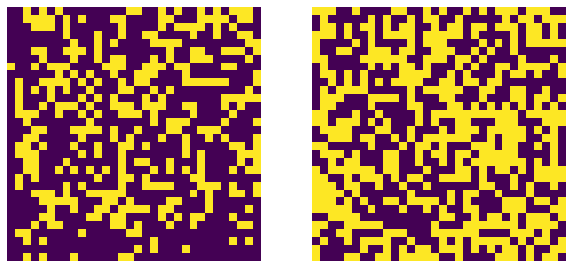

In [8]:
# small 3d u-net with concatenating skip connection
# original paper https://arxiv.org/abs/1505.04597
class Small3dUcat(nn.Module):
    def __init__(self,input_channels=4,num_filters=32):
        super(Small3dUcat,self).__init__()
        
        # Structure:
        # Conv,Conv,MaxPool,Conv,Conv,UnPool,Conv,Conv
        
        self.input_channels = input_channels
        self.num_filters = num_filters
        
        self.c1 = self.ConvLayer(in_channels=self.input_channels,out_channels=num_filters)
        self.c2 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)

        self.c3 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c4 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        
        self.c5 = self.ConvLayer(in_channels=2*num_filters,out_channels=num_filters)
        self.c6 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c7 = self.ConvLayer(in_channels=num_filters,out_channels=1)
    
    def forward(self, x_in, evaluating=False):
        x1 = self.c1(x_in)
        x1 = self.c2(x1)
        
        x2 = F.max_pool3d(x1,kernel_size=2)
        x2 = self.c3(x2)
        x2 = self.c4(x2)
        
        x2 = F.interpolate(x2, scale_factor=2)
        # concatenate x1,x2
        x = torch.cat([x1,x2],dim=1)
        x = self.c5(x)
        x = self.c6(x)
        x = self.c7(x)
        
        x_out = x.squeeze(1)
        
        if evaluating:
            x_out = torch.sigmoid(x_out)
            x_out = x_out.round()

        return x_out
    
    def ConvLayer(self, in_channels=32, out_channels=32, kernel_size=3,
                  stride=1, padding=1, bias=True, relu=True, batchnorm=True):
        layer = nn.Sequential()
        conv = nn.Conv3d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=padding,
                         bias=bias)
        layer.add_module('conv',conv)
        if relu:
            layer.add_module('relu',nn.ReLU())
        if batchnorm:
            layer.add_module('batchnorm',nn.BatchNorm3d(out_channels))

        return layer


model = Small3dUcat()
optimizer = torch.optim.Adam(model.parameters())
loss = nn.BCEWithLogitsLoss()
# should be of the form loss(y_pred,y)
simulator(model=model,loss=loss)

Input has shape (1, 4, 32, 32, 64).
Target has shape (1, 32, 32, 64).
Training output has shape (1, 32, 32, 64).
Loss is -0.001723131979815662.
Evaluation output has shape (1, 32, 32, 64).
IoU score is 0.2612839937210083.


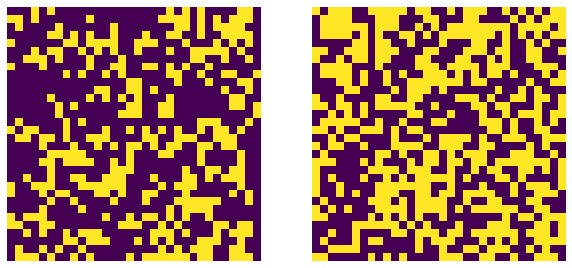

In [13]:
# small 3d u-net with addition skip connection
# original paper https://arxiv.org/abs/1505.04597
# a simple sequence of convolutional layers
class Small3dUadd(nn.Module):
    def __init__(self,input_channels=4,num_filters=32):
        super(Small3dUadd,self).__init__()
        
        # Structure:
        # Conv,Conv,MaxPool,Conv,Conv,UnPool,Conv,Conv
        
        self.input_channels = input_channels
        self.num_filters = num_filters
        
        self.c1 = self.ConvLayer(in_channels=self.input_channels,out_channels=num_filters)
        self.c2 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)

        self.c3 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c4 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        
        self.c5 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c6 = self.ConvLayer(in_channels=num_filters,out_channels=num_filters)
        self.c7 = self.ConvLayer(in_channels=num_filters,out_channels=1)
    
    def forward(self, x_in, evaluating=False):
        x1 = self.c1(x_in)
        x1 = self.c2(x1)
        
        x2 = F.max_pool3d(x1,kernel_size=2)
        x2 = self.c3(x2)
        x2 = self.c4(x2)
        
        x2 = F.interpolate(x2, scale_factor=2)
        # add x1,x2
        x = F.relu(x1+x2)
        x = self.c5(x)
        x = self.c6(x)
        x = self.c7(x)
        
        x_out = x.squeeze(1)
        
        if evaluating:
            x_out = torch.sigmoid(x_out)
            x_out = x_out.round()

        return x_out
    
    def ConvLayer(self, in_channels=32, out_channels=32, kernel_size=3,
                  stride=1, padding=1, bias=True, relu=True, batchnorm=True):
        layer = nn.Sequential()
        conv = nn.Conv3d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         padding=padding,
                         bias=bias)
        layer.add_module('conv',conv)
        if relu:
            layer.add_module('relu',nn.ReLU())
        if batchnorm:
            layer.add_module('batchnorm',nn.BatchNorm3d(out_channels))

        return layer


model = Small3dUadd()
optimizer = torch.optim.Adam(model.parameters())
# loss = nn.BCEWithLogitsLoss()
loss = iou_loss
# should be of the form loss(y_pred,y)
simulator(model=model,loss=loss)

In [14]:
loss.backward()
# paper discussing segmentation in medical imaging
# https://arxiv.org/pdf/1701.03056.pdf

AttributeError: 'function' object has no attribute 'backward'

In [ ]:
x = torch.tensor([1,2,3])
y = torch.tensor([1,2,4])

In [ ]:
x+y

In [ ]:
x*y

In [ ]:
# create Jaccard loss module
# page 7: https://arxiv.org/pdf/1701.03056.pdf 
# do a big U-net like in that paper
# do a 2d version of that
# create dataset class
# train!